In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Load data

In [2]:
samples = pd.read_csv("dataset_mood_smartphone.csv", 
                      sep=',', 
                      index_col=0, 
                      parse_dates=["time"],
                      dtype={"id": "category", "variable": "category"}, 
                      verbose=True)
samples = samples.rename(columns={"time": "datetime"})
samples

Tokenization took: 22.93 ms
Type conversion took: 25.91 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 22.36 ms
Type conversion took: 35.74 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 19.22 ms
Type conversion took: 29.19 ms
Parser memory cleanup took: 0.00 ms


,id,datetime,variable,value
1,AS14.01,2014-02-26 13:00:00.000,mood,6.000
2,AS14.01,2014-02-26 15:00:00.000,mood,6.000
3,AS14.01,2014-02-26 18:00:00.000,mood,6.000
4,AS14.01,2014-02-26 21:00:00.000,mood,7.000
5,AS14.01,2014-02-27 09:00:00.000,mood,6.000
...,...,...,...,...
2770399,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032
2772465,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008
2774026,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026
2774133,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033


## Check contents

In [3]:
samples.dtypes

id                category
datetime    datetime64[ns]
variable          category
value              float64
dtype: object

In [4]:
samples.dtypes.value_counts()

category          1
datetime64[ns]    1
category          1
float64           1
dtype: int64

In [5]:
samples["datetime"].nunique()

336907

In [6]:
ids = samples["id"].unique()
ids

['AS14.01', 'AS14.02', 'AS14.03', 'AS14.05', 'AS14.06', ..., 'AS14.29', 'AS14.30', 'AS14.31', 'AS14.32', 'AS14.33']
Length: 27
Categories (27, object): ['AS14.01', 'AS14.02', 'AS14.03', 'AS14.05', ..., 'AS14.30', 'AS14.31', 'AS14.32', 'AS14.33']

In [7]:
variables = samples["variable"].unique()
variables

['mood', 'circumplex.arousal', 'circumplex.valence', 'activity', 'screen', ..., 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather']
Length: 19
Categories (19, object): ['activity', 'circumplex.arousal', 'circumplex.valence', 'mood', ..., 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather']

In [8]:
list(variables)

['mood',
 'circumplex.arousal',
 'circumplex.valence',
 'activity',
 'screen',
 'call',
 'sms',
 'appCat.builtin',
 'appCat.communication',
 'appCat.entertainment',
 'appCat.finance',
 'appCat.game',
 'appCat.office',
 'appCat.other',
 'appCat.social',
 'appCat.travel',
 'appCat.unknown',
 'appCat.utilities',
 'appCat.weather']

## Remove duplicate entries

In [9]:
dupes = samples.duplicated(subset=['datetime', 'variable', 'id'], keep='last')
dupes[dupes == True]

136      True
359      True
372      True
938      True
1749     True
1874     True
2670     True
3061     True
3967     True
3997     True
4617     True
4636     True
5528     True
5777     True
5829     True
6001     True
6014     True
6226     True
6581     True
7392     True
7517     True
8974     True
9400     True
9610     True
10259    True
10278    True
10372    True
11171    True
11420    True
11472    True
11644    True
11657    True
11869    True
12224    True
13035    True
13160    True
14617    True
15043    True
15253    True
15902    True
15921    True
16015    True
16814    True
dtype: bool

In [10]:
samples_deduped = samples[dupes == False]
samples_deduped

,id,datetime,variable,value
1,AS14.01,2014-02-26 13:00:00.000,mood,6.000
2,AS14.01,2014-02-26 15:00:00.000,mood,6.000
3,AS14.01,2014-02-26 18:00:00.000,mood,6.000
4,AS14.01,2014-02-26 21:00:00.000,mood,7.000
5,AS14.01,2014-02-27 09:00:00.000,mood,6.000
...,...,...,...,...
2770399,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032
2772465,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008
2774026,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026
2774133,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033


## Pivot the data to a time indexed data frame 
https://pandas.pydata.org/docs/user_guide/reshaping.html

In [167]:
vdata = samples_deduped.pivot(index="datetime", columns=["id", "variable"], values="value")
vdata

id,AS14.01,AS14.02,AS14.03,AS14.05,AS14.06,AS14.07,AS14.08,AS14.09,AS14.12,AS14.13,...,AS14.06,AS14.09,AS14.12,AS14.16,AS14.25,AS14.26,AS14.27,AS14.28,AS14.30,AS14.32
variable,mood,mood,mood,mood,mood,mood,mood,mood,mood,mood,...,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather
datetime,,,,,,,,,,,,,,,,,,,,,
2014-02-17 07:00:52.197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 07:12:13.631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 07:49:19.635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 08:57:16.313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 08:58:58.471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-08 11:03:34.453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-08 11:04:20.233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [169]:
vdata.columns

MultiIndex([('AS14.01',           'mood'),
            ('AS14.02',           'mood'),
            ('AS14.03',           'mood'),
            ('AS14.05',           'mood'),
            ('AS14.06',           'mood'),
            ('AS14.07',           'mood'),
            ('AS14.08',           'mood'),
            ('AS14.09',           'mood'),
            ('AS14.12',           'mood'),
            ('AS14.13',           'mood'),
            ...
            ('AS14.06', 'appCat.weather'),
            ('AS14.09', 'appCat.weather'),
            ('AS14.12', 'appCat.weather'),
            ('AS14.16', 'appCat.weather'),
            ('AS14.25', 'appCat.weather'),
            ('AS14.26', 'appCat.weather'),
            ('AS14.27', 'appCat.weather'),
            ('AS14.28', 'appCat.weather'),
            ('AS14.30', 'appCat.weather'),
            ('AS14.32', 'appCat.weather')],
           names=['id', 'variable'], length=464)

In [218]:
vdata.columns.get_level_values(0).categories

Index(['AS14.01', 'AS14.02', 'AS14.03', 'AS14.05', 'AS14.06', 'AS14.07',
       'AS14.08', 'AS14.09', 'AS14.12', 'AS14.13', 'AS14.14', 'AS14.15',
       'AS14.16', 'AS14.17', 'AS14.19', 'AS14.20', 'AS14.23', 'AS14.24',
       'AS14.25', 'AS14.26', 'AS14.27', 'AS14.28', 'AS14.29', 'AS14.30',
       'AS14.31', 'AS14.32', 'AS14.33'],
      dtype='object')

In [161]:
vdata.columns.get_level_values(1).categories

Index(['AS14.01', 'AS14.02', 'AS14.03', 'AS14.05', 'AS14.06', 'AS14.07',
       'AS14.08', 'AS14.09', 'AS14.12', 'AS14.13', 'AS14.14', 'AS14.15',
       'AS14.16', 'AS14.17', 'AS14.19', 'AS14.20', 'AS14.23', 'AS14.24',
       'AS14.25', 'AS14.26', 'AS14.27', 'AS14.28', 'AS14.29', 'AS14.30',
       'AS14.31', 'AS14.32', 'AS14.33'],
      dtype='object')

In [170]:
vdata.index.names

FrozenList(['datetime'])

In [171]:
vdata.index

DatetimeIndex(['2014-02-17 07:00:52.197000', '2014-02-17 07:12:13.631000',
               '2014-02-17 07:49:19.635000', '2014-02-17 08:57:16.313000',
               '2014-02-17 08:58:58.471000', '2014-02-17 09:00:42.312000',
               '2014-02-17 09:01:34.747000', '2014-02-17 09:48:49.536000',
               '2014-02-17 09:52:02.075000', '2014-02-17 09:58:59.766000',
               ...
                      '2014-06-08 10:00:00', '2014-06-08 10:50:46.150000',
               '2014-06-08 10:50:46.178000', '2014-06-08 10:54:22.891000',
                      '2014-06-08 11:00:00', '2014-06-08 11:03:34.453000',
               '2014-06-08 11:04:20.233000', '2014-06-08 11:04:36.299000',
               '2014-06-08 11:04:46.335000',        '2014-06-09 00:00:00'],
              dtype='datetime64[ns]', name='datetime', length=336907, freq=None)

In [177]:
vdata["AS14.01"]

variable,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather
datetime,,,,,,,,,,,,,,,,,,,
2014-02-17 07:00:52.197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 07:12:13.631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 07:49:19.635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 08:57:16.313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 08:58:58.471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-08 11:03:34.453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-08 11:04:20.233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-08 11:04:36.299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [175]:
vdata["AS14.01"]["mood"]

datetime
2014-02-17 07:00:52.197   NaN
2014-02-17 07:12:13.631   NaN
2014-02-17 07:49:19.635   NaN
2014-02-17 08:57:16.313   NaN
2014-02-17 08:58:58.471   NaN
                           ..
2014-06-08 11:03:34.453   NaN
2014-06-08 11:04:20.233   NaN
2014-06-08 11:04:36.299   NaN
2014-06-08 11:04:46.335   NaN
2014-06-09 00:00:00.000   NaN
Name: mood, Length: 336907, dtype: float64

In [176]:
type(vdata["AS14.01"]["mood"])

pandas.core.series.Series

## Experimenting with resampling

<Axes: xlabel='datetime'>

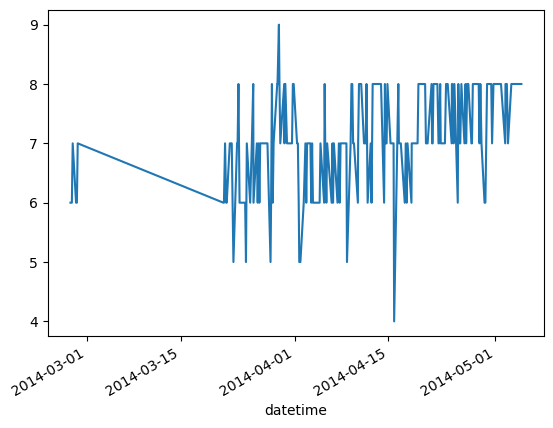

In [191]:
var = vdata["AS14.01"]["mood"]
var[var.notnull()].plot()

<Axes: xlabel='datetime'>

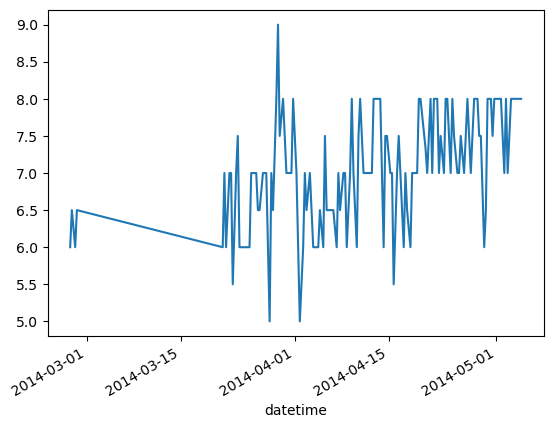

In [192]:
daily_var = var.resample("6H").mean()
daily_var[daily_var.notnull()].plot()

<Axes: xlabel='datetime'>

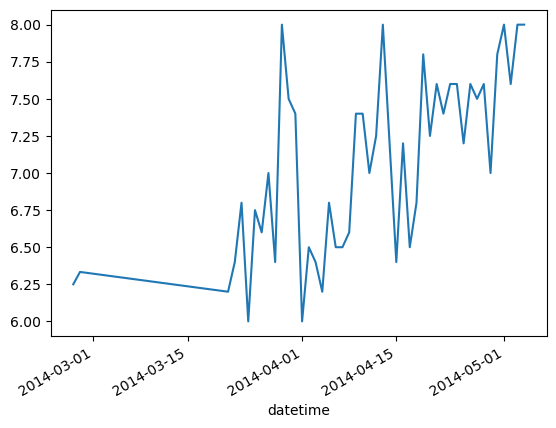

In [193]:
daily_var = var.resample("D").mean()
daily_var[daily_var.notnull()].plot()

<Axes: xlabel='datetime'>

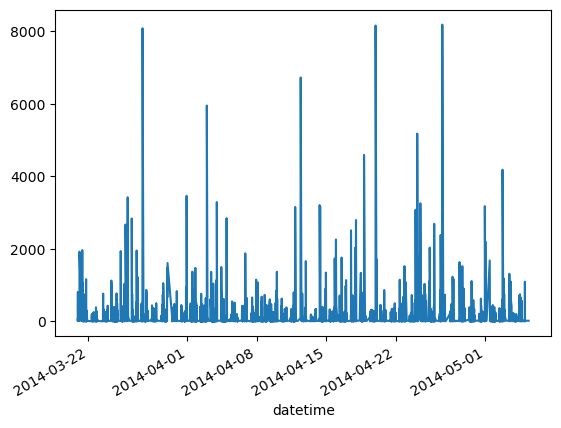

In [195]:
var = vdata["AS14.01"]["screen"]
var[var.notnull()].plot()

<Axes: xlabel='datetime'>

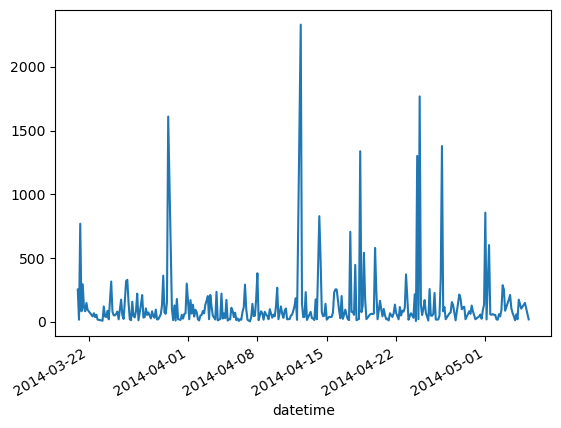

In [196]:
daily_var = var.resample("3H").mean()
daily_var[daily_var.notnull()].plot()

<Axes: xlabel='datetime'>

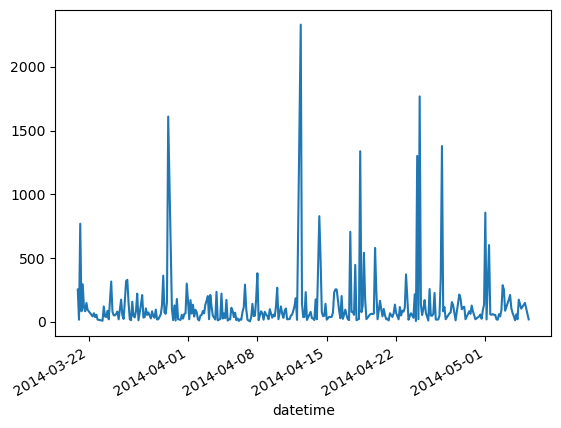

In [196]:
daily_var = var.resample("3H").mean()
daily_var[daily_var.notnull()].plot()

<Axes: xlabel='datetime'>

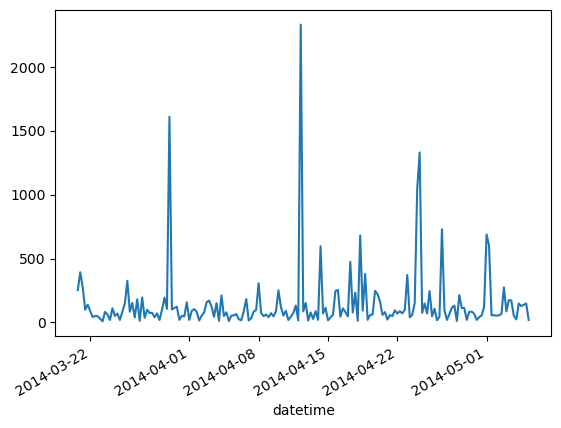

In [197]:
daily_var = var.resample("6H").mean()
daily_var[daily_var.notnull()].plot()

<Axes: xlabel='datetime'>

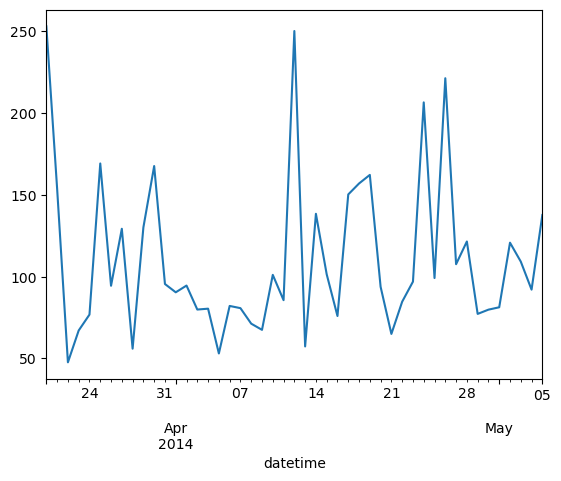

In [198]:
daily_var = var.resample("D").mean()
daily_var[daily_var.notnull()].plot()

In [201]:
daily = vdata.resample("D").sum()
daily

id,AS14.01,AS14.02,AS14.03,AS14.05,AS14.06,AS14.07,AS14.08,AS14.09,AS14.12,AS14.13,...,AS14.06,AS14.09,AS14.12,AS14.16,AS14.25,AS14.26,AS14.27,AS14.28,AS14.30,AS14.32
variable,mood,mood,mood,mood,mood,mood,mood,mood,mood,mood,...,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather
datetime,,,,,,,,,,,,,,,,,,,,,
2014-02-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-02-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-02-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-02-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-02-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-06-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [203]:
subject = 'AS14.01'
df = daily[subject]
df

variable,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather
datetime,,,,,,,,,,,,,,,,,,,
2014-02-17,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-02-18,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-02-19,0.0,0.0,0.0,0.0,0.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-02-20,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-02-21,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-06-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-06-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


array([<Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>], dtype=object)

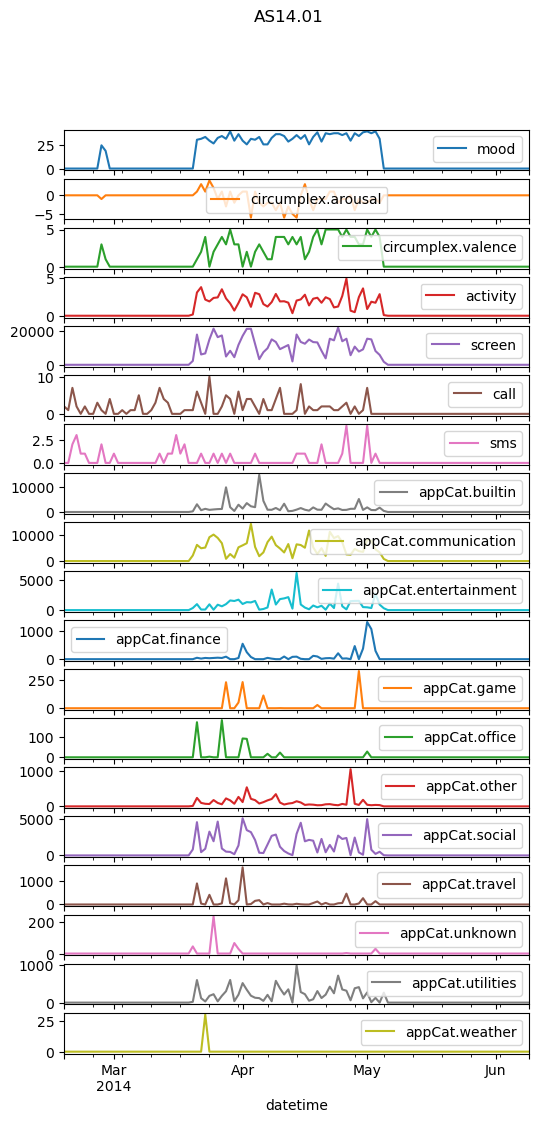

In [211]:
df.plot(subplots=True, figsize=(6,12), title=subject)

array([<Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>,
       <Axes: xlabel='datetime'>], dtype=object)

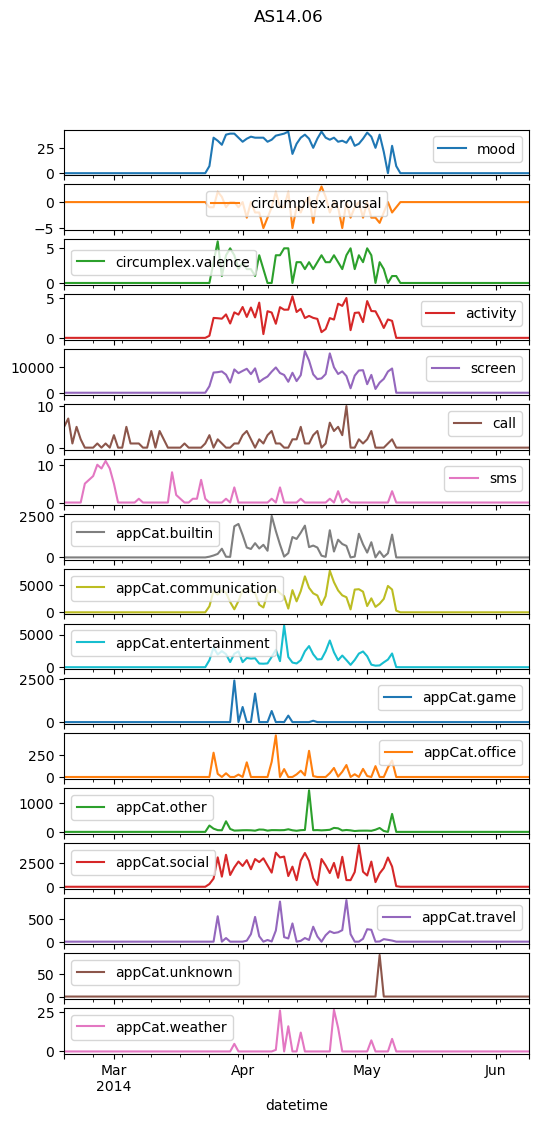

In [216]:
subject = 'AS14.06'
daily[subject].plot(subplots=True, figsize=(6,12), title=subject)

## Alternative indexing
Obsolete, skip everything below

In [86]:
hdata = samples_deduped.pivot(columns="datetime", index=["id", "variable"], values="value")
hdata

datetime                    2014-02-17 07:00:52.197  2014-02-17 07:12:13.631  \
id      variable                                                               
AS14.01 activity                                NaN                      NaN   
        circumplex.arousal                      NaN                      NaN   
        circumplex.valence                      NaN                      NaN   
        mood                                    NaN                      NaN   
        screen                                  NaN                      NaN   
...                                             ...                      ...   
AS14.33 appCat.other                            NaN                      NaN   
        appCat.social                           NaN                      NaN   
        appCat.travel                           NaN                      NaN   
        appCat.unknown                          NaN                      NaN   
        appCat.utilities                        NaN                      NaN   

datetime                    2014-02-17 07:49:19.635  2014-02-17 08:57:16.313  \
id      variable                                                               
AS14.01 activity                                NaN                      NaN   
        circumplex.arousal                      NaN                      NaN   
        circumplex.valence                      NaN                      NaN   
        mood                                    NaN                      NaN   
        screen                                  NaN                      NaN   
...                                             ...                      ...   
AS14.33 appCat.other                            NaN                      NaN   
        appCat.social                           NaN                      NaN   
        appCat.travel                           NaN                      NaN   
        appCat.unknown                          NaN                      NaN   
        appCat.utilities                        NaN                      NaN   

datetime                    2014-02-17 08:58:58.471  2014-02-17 09:00:42.312  \
id      variable                                                               
AS14.01 activity                                NaN                      NaN   
        circumplex.arousal                      NaN                      NaN   
        circumplex.valence                      NaN                      NaN   
        mood                                    NaN                      NaN   
        screen                                  NaN                      NaN   
...                                             ...                      ...   
AS14.33 appCat.other                            NaN                      NaN   
        appCat.social                           NaN                      NaN   
        appCat.travel                           NaN                      NaN   
        appCat.unknown                          NaN                      NaN   
        appCat.utilities                        NaN                      NaN   

datetime                    2014-02-17 09:01:34.747  2014-02-17 09:48:49.536  \
id      variable                                                               
AS14.01 activity                                NaN                      NaN   
        circumplex.arousal                      NaN                      NaN   
        circumplex.valence                      NaN                      NaN   
        mood                                    NaN                      NaN   
        screen                                  NaN                      NaN   
...                                             ...                      ...   
AS14.33 appCat.other                            NaN                      NaN   
        appCat.social                           NaN                      NaN   
        appCat.travel                           NaN                      NaN 

In [87]:
hdata.index.names

FrozenList(['id', 'variable'])

In [88]:
hdata.index.get_level_values(0)

CategoricalIndex(['AS14.01', 'AS14.01', 'AS14.01', 'AS14.01', 'AS14.01',
                  'AS14.01', 'AS14.01', 'AS14.01', 'AS14.01', 'AS14.01',
                  ...
                  'AS14.33', 'AS14.33', 'AS14.33', 'AS14.33', 'AS14.33',
                  'AS14.33', 'AS14.33', 'AS14.33', 'AS14.33', 'AS14.33'],
                 categories=['AS14.01', 'AS14.02', 'AS14.03', 'AS14.05', ..., 'AS14.30', 'AS14.31', 'AS14.32', 'AS14.33'], ordered=False, dtype='category', name='id', length=464)

In [89]:
hdata.index.get_level_values(1)

CategoricalIndex(['activity', 'circumplex.arousal', 'circumplex.valence',
                  'mood', 'screen', 'appCat.builtin', 'appCat.communication',
                  'call', 'sms', 'appCat.entertainment',
                  ...
                  'call', 'sms', 'appCat.entertainment', 'appCat.finance',
                  'appCat.office', 'appCat.other', 'appCat.social',
                  'appCat.travel', 'appCat.unknown', 'appCat.utilities'],
                 categories=['activity', 'circumplex.arousal', 'circumplex.valence', 'mood', ..., 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather'], ordered=False, dtype='category', name='variable', length=464)

In [90]:
hdata.loc[("AS14.01", "mood")]

datetime
2014-02-17 07:00:52.197   NaN
2014-02-17 07:12:13.631   NaN
2014-02-17 07:49:19.635   NaN
2014-02-17 08:57:16.313   NaN
2014-02-17 08:58:58.471   NaN
                           ..
2014-06-08 11:03:34.453   NaN
2014-06-08 11:04:20.233   NaN
2014-06-08 11:04:36.299   NaN
2014-06-08 11:04:46.335   NaN
2014-06-09 00:00:00.000   NaN
Name: (AS14.01, mood), Length: 336907, dtype: float64

In [91]:
type(hdata.loc[("AS14.01", "mood")])

pandas.core.series.Series

In [92]:
hdata.loc["AS14.01"]

datetime,2014-02-17 07:00:52.197,2014-02-17 07:12:13.631,2014-02-17 07:49:19.635,2014-02-17 08:57:16.313,2014-02-17 08:58:58.471,2014-02-17 09:00:42.312,2014-02-17 09:01:34.747,2014-02-17 09:48:49.536,2014-02-17 09:52:02.075,2014-02-17 09:58:59.766,...,2014-06-08 10:00:00.000,2014-06-08 10:50:46.150,2014-06-08 10:50:46.178,2014-06-08 10:54:22.891,2014-06-08 11:00:00.000,2014-06-08 11:03:34.453,2014-06-08 11:04:20.233,2014-06-08 11:04:36.299,2014-06-08 11:04:46.335,2014-06-09 00:00:00.000
variable,,,,,,,,,,,,,,,,,,,,,
activity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
circumplex.arousal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
circumplex.valence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
screen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
appCat.builtin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
appCat.communication,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
call,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
hdata.loc[("AS14.01",),]

datetime,2014-02-17 07:00:52.197,2014-02-17 07:12:13.631,2014-02-17 07:49:19.635,2014-02-17 08:57:16.313,2014-02-17 08:58:58.471,2014-02-17 09:00:42.312,2014-02-17 09:01:34.747,2014-02-17 09:48:49.536,2014-02-17 09:52:02.075,2014-02-17 09:58:59.766,...,2014-06-08 10:00:00.000,2014-06-08 10:50:46.150,2014-06-08 10:50:46.178,2014-06-08 10:54:22.891,2014-06-08 11:00:00.000,2014-06-08 11:03:34.453,2014-06-08 11:04:20.233,2014-06-08 11:04:36.299,2014-06-08 11:04:46.335,2014-06-09 00:00:00.000
variable,,,,,,,,,,,,,,,,,,,,,
activity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
circumplex.arousal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
circumplex.valence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
screen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
appCat.builtin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
appCat.communication,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
call,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sms,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Observations per subject

<Axes: >

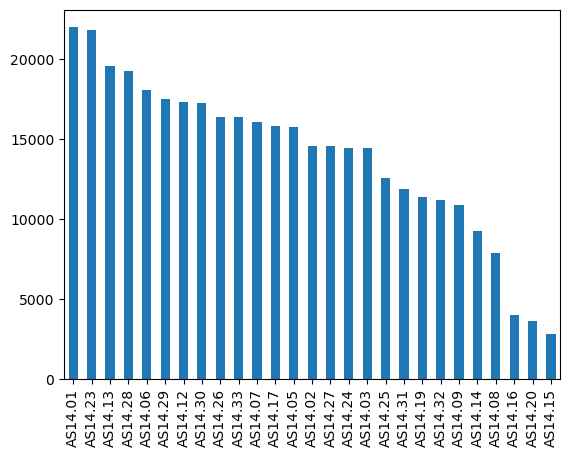

In [22]:
samples["id"].value_counts().plot(kind="bar")

## Observations per variables

<Axes: >

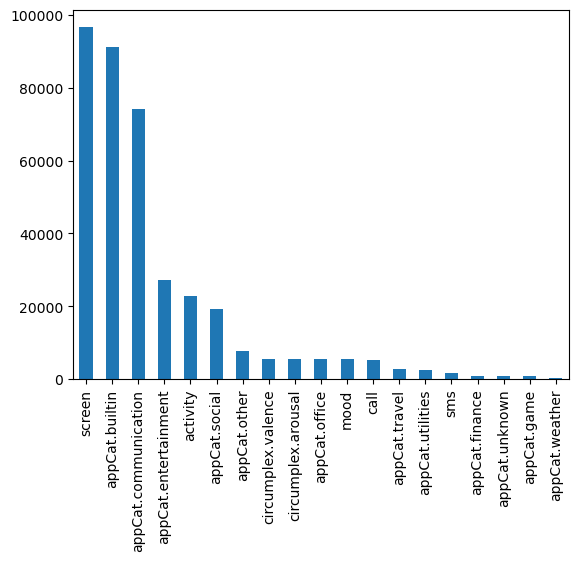

In [23]:
samples['variable'].value_counts().plot(kind="bar")

In [24]:
as1401 = samples[(samples["id"] == "AS14.01") & (samples["variable"] == "mood")]
as1415 = samples[(samples["id"] == "AS14.15") & (samples["variable"] == "mood")]
as1401

,id,datetime,variable,value
1,AS14.01,2014-02-26 13:00:00,mood,6.0
2,AS14.01,2014-02-26 15:00:00,mood,6.0
3,AS14.01,2014-02-26 18:00:00,mood,6.0
4,AS14.01,2014-02-26 21:00:00,mood,7.0
5,AS14.01,2014-02-27 09:00:00,mood,6.0
...,...,...,...,...
218,AS14.01,2014-05-03 21:00:00,mood,8.0
219,AS14.01,2014-05-04 11:00:00,mood,8.0
220,AS14.01,2014-05-04 12:00:00,mood,8.0
221,AS14.01,2014-05-04 15:00:00,mood,8.0


In [25]:
samples["id"].unique()

['AS14.01', 'AS14.02', 'AS14.03', 'AS14.05', 'AS14.06', ..., 'AS14.29', 'AS14.30', 'AS14.31', 'AS14.32', 'AS14.33']
Length: 27
Categories (27, object): ['AS14.01', 'AS14.02', 'AS14.03', 'AS14.05', ..., 'AS14.30', 'AS14.31', 'AS14.32', 'AS14.33']

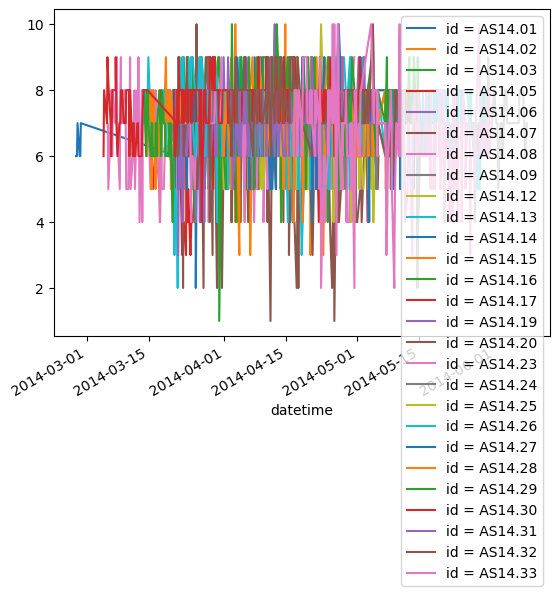

In [26]:
fig, ax = plt.subplots()
for i in samples["id"].unique():
    samples[(samples["id"] == i) & (samples["variable"] == "mood")].plot(x="datetime", y="value", ax=ax, label='id = %s'%i)


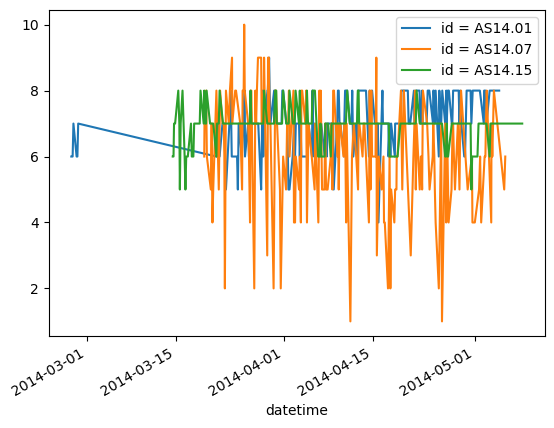

In [27]:
fig, ax = plt.subplots()
for i in ["AS14.01", "AS14.07", "AS14.15"]:
    samples[(samples["id"] == i) & (samples["variable"] == "mood")].plot(x="datetime", y="value", ax=ax, label='id = %s'%i)


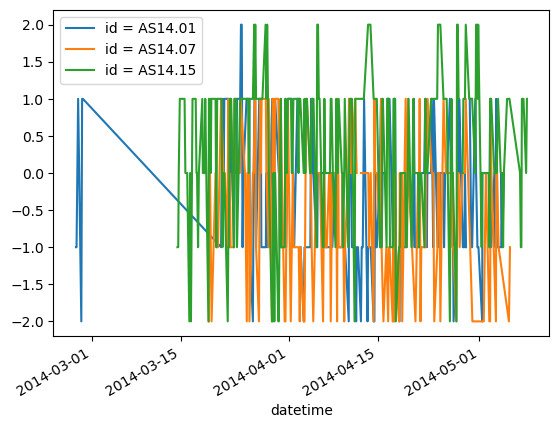

In [28]:
fig, ax = plt.subplots()
for i in ["AS14.01", "AS14.07", "AS14.15"]:
    samples[(samples["id"] == i) & (samples["variable"] == "circumplex.arousal")].plot(x="datetime", y="value", ax=ax, label='id = %s'%i)


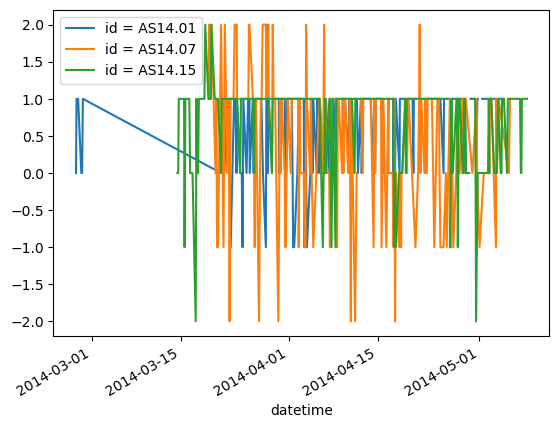

In [29]:
fig, ax = plt.subplots()
for i in ["AS14.01", "AS14.07", "AS14.15"]:
    samples[(samples["id"] == i) & (samples["variable"] == "circumplex.valence")].plot(x="datetime", y="value", ax=ax, label='id = %s'%i)


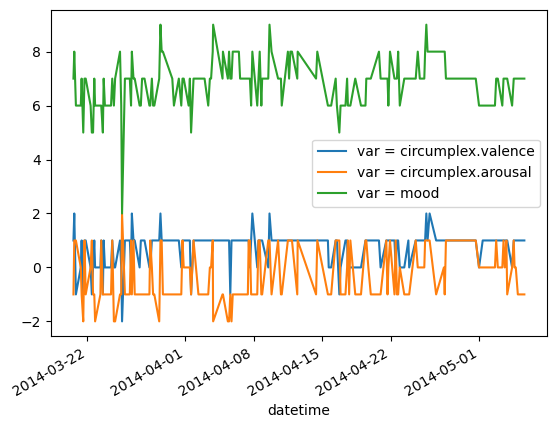

In [30]:
fig, ax = plt.subplots()
i = "AS14.14"
for v in ["circumplex.valence", "circumplex.arousal", "mood"]:
    samples[(samples["id"] == i) & (samples["variable"] == v)].plot(x="datetime", y="value", ax=ax, label='var = %s'%v)


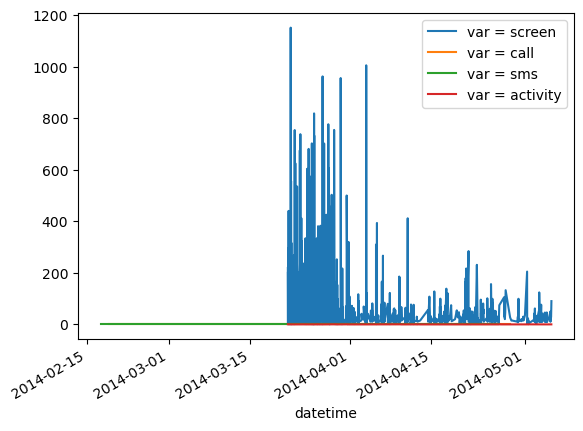

In [31]:
fig, ax = plt.subplots()
i = "AS14.14"
for v in ["screen", "call", "sms", "activity"]:
    samples[(samples["id"] == i) & (samples["variable"] == v)].plot(x="datetime", y="value", ax=ax, label='var = %s'%v)


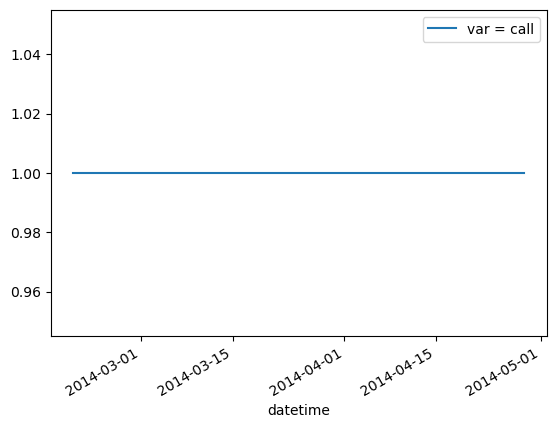

In [220]:
fig, ax = plt.subplots()
i = "AS14.14"
for v in ["call"]:
    samples[(samples["id"] == i) & (samples["variable"] == v)].plot(x="datetime", y="value", ax=ax, label='var = %s'%v)


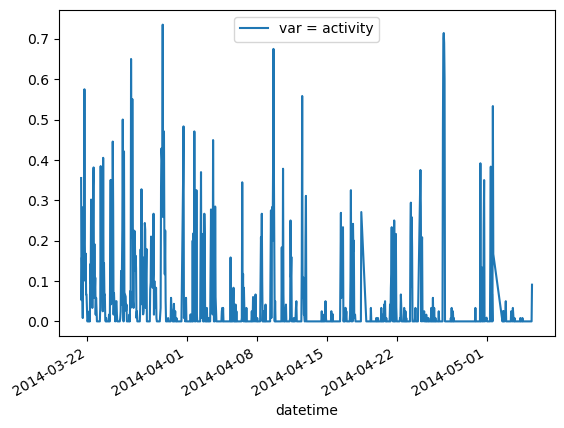

In [219]:
fig, ax = plt.subplots()
i = "AS14.14"
for v in ["activity"]:
    samples[(samples["id"] == i) & (samples["variable"] == v)].plot(x="datetime", y="value", ax=ax, label='var = %s'%v)


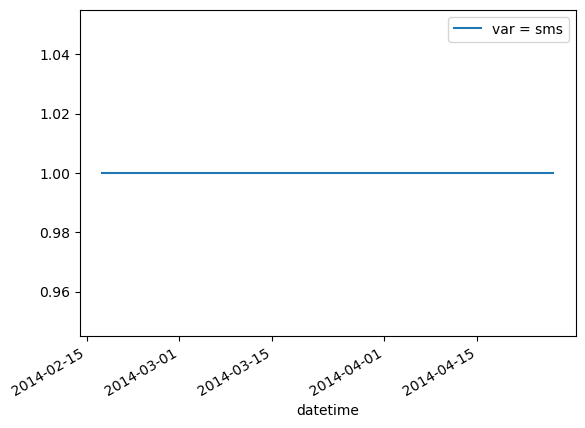

In [96]:
fig, ax = plt.subplots()
i = "AS14.14"
for v in ["sms"]:
    samples[(samples["id"] == i) & (samples["variable"] == v)].plot(x="datetime", y="value", ax=ax, label='var = %s'%v)
